[ADF] X
  Test statistic : -17.8394
  p-value        : 0.0000
  Critical values: {'1%': np.float64(-3.4524113009049935), '5%': np.float64(-2.8712554127251764), '10%': np.float64(-2.571946570731871)}
  => Stationary

[ADF] Y
  Test statistic : -17.5190
  p-value        : 0.0000
  Critical values: {'1%': np.float64(-3.4524113009049935), '5%': np.float64(-2.8712554127251764), '10%': np.float64(-2.571946570731871)}
  => Stationary

동시 상관계수 (Pearson): 0.0577



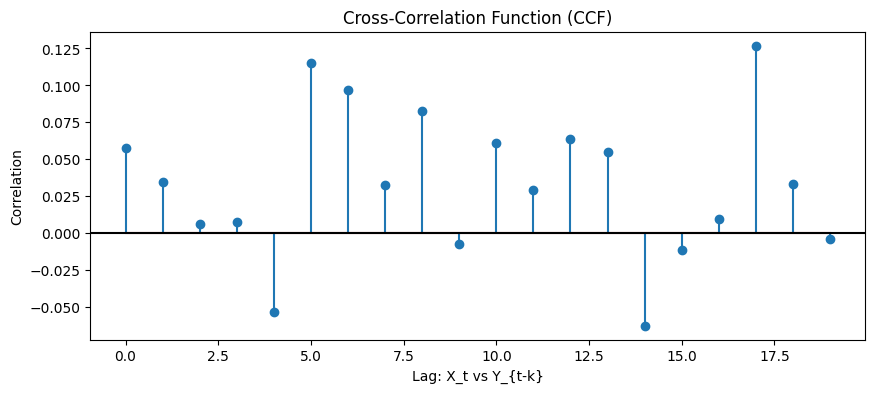

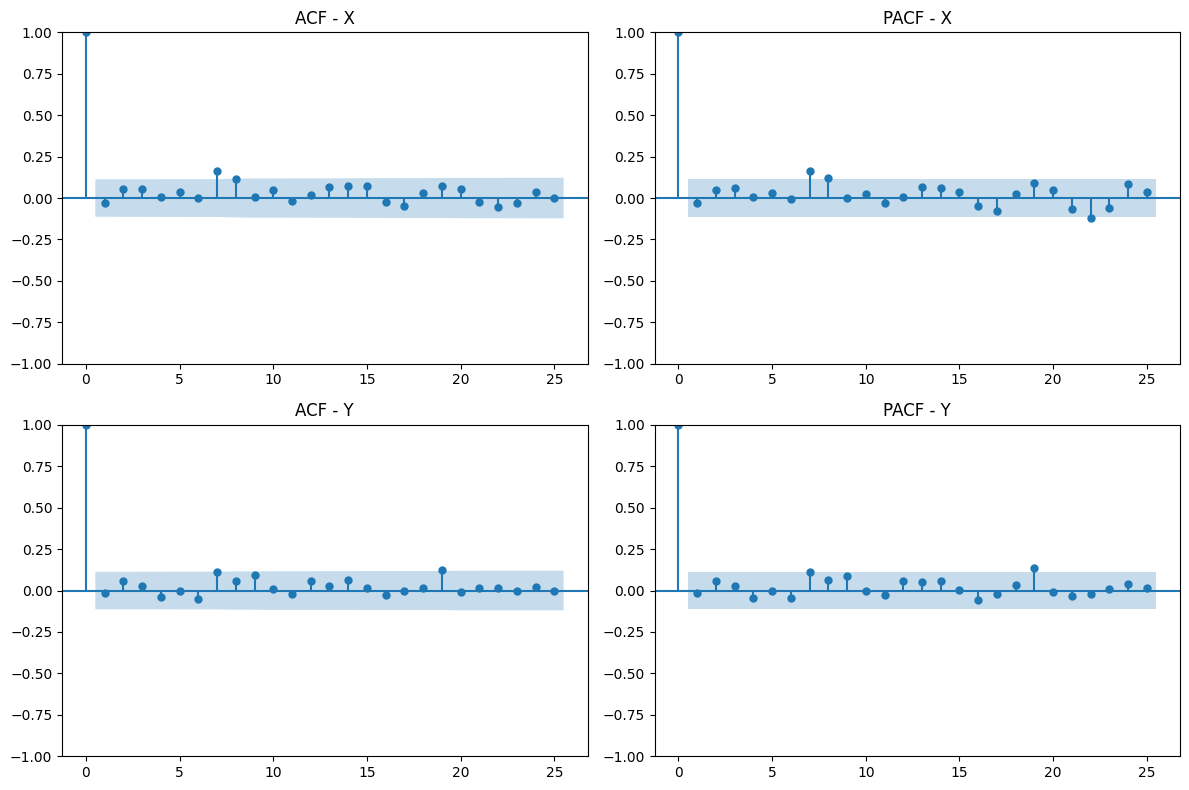

===== Granger Causality Test: Does X → Y? =====

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2619  , p=0.6092  , df_denom=296, df_num=1
ssr based chi2 test:   chi2=0.2646  , p=0.6070  , df=1
likelihood ratio test: chi2=0.2644  , p=0.6071  , df=1
parameter F test:         F=0.2619  , p=0.6092  , df_denom=296, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=465.8691, p=0.0000  , df_denom=293, df_num=2
ssr based chi2 test:   chi2=947.6382, p=0.0000  , df=2
likelihood ratio test: chi2=426.2323, p=0.0000  , df=2
parameter F test:         F=465.8691, p=0.0000  , df_denom=293, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=304.4101, p=0.0000  , df_denom=290, df_num=3
ssr based chi2 test:   chi2=935.2738, p=0.0000  , df=3
likelihood ratio test: chi2=422.5966, p=0.0000  , df=3
parameter F test:         F=304.4101, p=0.0000  , df_denom=290, df_num=3

Granger Causality
number of lags (no zero) 4


/home/yypark/miniconda3/envs/ai_env/lib/python3.12/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/home/yypark/miniconda3/envs/ai_env/lib/python3.12/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(



==== ARIMA Model Summary (X variable) ====
                               SARIMAX Results                                
Dep. Variable:                      X   No. Observations:                  300
Model:                 ARIMA(1, 0, 1)   Log Likelihood                -424.036
Date:                Sun, 23 Nov 2025   AIC                            856.072
Time:                        07:46:24   BIC                            870.887
Sample:                             0   HQIC                           862.001
                                - 300                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0475      0.095      0.498      0.618      -0.139       0.234
ar.L1          0.9448      0.066     14.249      0.000       0.815       1.075
ma.L1   

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.tsa.stattools import adfuller, ccf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.api import VAR
from statsmodels.tsa.arima.model import ARIMA


# =======================================================
# 1. 예시 데이터 생성 (stationary)
# =======================================================
np.random.seed(0)
n = 300

X = np.random.normal(size=n)
Y = 0.7 * np.roll(X, 2) + np.random.normal(scale=0.4, size=n)  # lag=2 관계 포함

df = pd.DataFrame({"X": X, "Y": Y})


# =======================================================
# 2. ADF Test (Stationarity)
# =======================================================
def adf_test(series, name):
    res = adfuller(series)
    print(f"[ADF] {name}")
    print(f"  Test statistic : {res[0]:.4f}")
    print(f"  p-value        : {res[1]:.4f}")
    print(f"  Critical values: {res[4]}")
    print("  => Stationary\n" if res[1] < 0.05 else "  => NOT Stationary\n")

adf_test(df["X"], "X")
adf_test(df["Y"], "Y")


# =======================================================
# 3. Pearson Correlation & CCF
# =======================================================
corr = df["X"].corr(df["Y"])
print(f"동시 상관계수 (Pearson): {corr:.4f}\n")

lags = 20
ccf_values = ccf(df["X"], df["Y"])[:lags]

plt.figure(figsize=(10,4))
plt.stem(range(lags), ccf_values,
         #use_line_collection=True
         )
plt.axhline(0, color='black')
plt.title("Cross-Correlation Function (CCF)")
plt.xlabel("Lag: X_t vs Y_{t-k}")
plt.ylabel("Correlation")
plt.show()


# =======================================================
# 4. ACF / PACF plots
# =======================================================
fig, ax = plt.subplots(2, 2, figsize=(12, 8))

plot_acf(df["X"], ax=ax[0,0])
ax[0,0].set_title("ACF - X")

plot_pacf(df["X"], method="ywm", ax=ax[0,1])
ax[0,1].set_title("PACF - X")

plot_acf(df["Y"], ax=ax[1,0])
ax[1,0].set_title("ACF - Y")

plot_pacf(df["Y"], method="ywm", ax=ax[1,1])
ax[1,1].set_title("PACF - Y")

plt.tight_layout()
plt.show()


# =======================================================
# 5. Granger Causality Test
# =======================================================
print("===== Granger Causality Test: Does X → Y? =====")
grangercausalitytests(df[["Y", "X"]], maxlag=5, verbose=True)

print("\n===== Granger Causality Test: Does Y → X? =====")
grangercausalitytests(df[["X", "Y"]], maxlag=5, verbose=True)


# =======================================================
# 6. VAR 모델 적합 및 예측
# =======================================================
model = VAR(df)
results = model.fit(5)
print(results.summary())

# 5-step ahead forecast
forecast = results.forecast(df.values[-5:], steps=5)
print("\nVAR Forecast (5 steps):\n", forecast)


# =======================================================
# 7. ARIMA 모델 예시 (X 변수 하나만)
# =======================================================
arima_model = ARIMA(df["X"], order=(1,0,1))
arima_results = arima_model.fit()

print("\n==== ARIMA Model Summary (X variable) ====")
print(arima_results.summary())

# Forecast next 5 steps
arima_forecast = arima_results.forecast(5)
print("\nARIMA Forecast (next 5 steps):")
print(arima_forecast)


In [14]:
heat_df_pivot = heat_df.pivot_table(values="corr", 
                    #index=[0], 
                    columns="lag")

In [16]:
print(f'np.argmax(heat_df_pivot): {np.argmax(heat_df_pivot)}')
print(f'heat_df_pivot.iloc[:, np.argmax(heat_df_pivot)]: {heat_df_pivot.iloc[:, np.argmax(heat_df_pivot)].values}')

np.argmax(heat_df_pivot): 17
heat_df_pivot.iloc[:, np.argmax(heat_df_pivot)]: [0.84154557]


[ADF] X
  Test statistic : -17.8394
  p-value        : 0.0000
  Critical values: {'1%': np.float64(-3.4524113009049935), '5%': np.float64(-2.8712554127251764), '10%': np.float64(-2.571946570731871)}
  => Stationary

[ADF] Y
  Test statistic : -17.3603
  p-value        : 0.0000
  Critical values: {'1%': np.float64(-3.4524113009049935), '5%': np.float64(-2.8712554127251764), '10%': np.float64(-2.571946570731871)}
  => Stationary

동시 상관계수 (Pearson): 0.0661



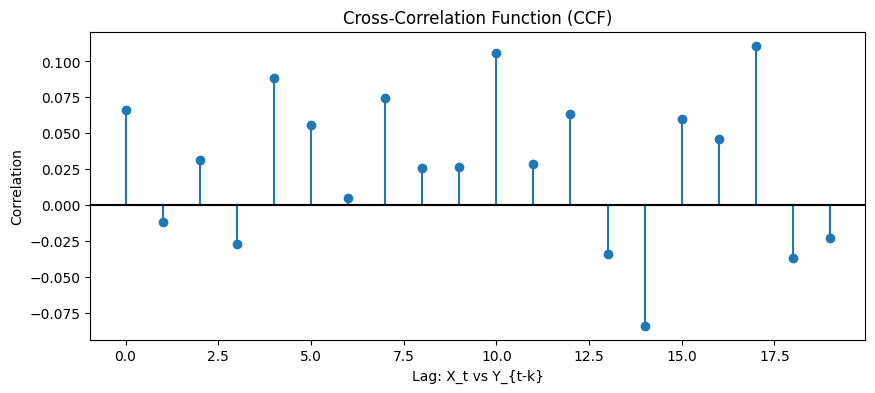

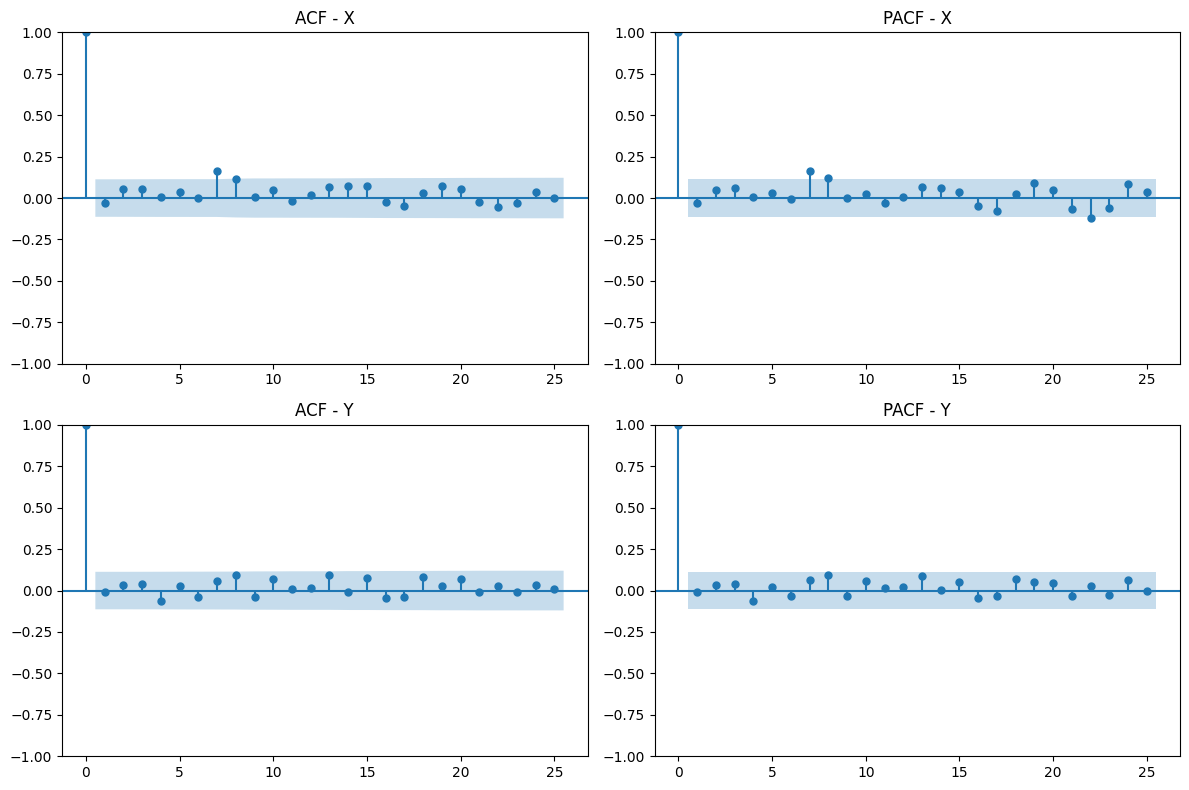

===== Granger Causality Test: Does X → Y? =====

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.3174  , p=0.5736  , df_denom=296, df_num=1
ssr based chi2 test:   chi2=0.3206  , p=0.5713  , df=1
likelihood ratio test: chi2=0.3204  , p=0.5714  , df=1
parameter F test:         F=0.3174  , p=0.5736  , df_denom=296, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.1506  , p=0.8602  , df_denom=293, df_num=2
ssr based chi2 test:   chi2=0.3064  , p=0.8579  , df=2
likelihood ratio test: chi2=0.3063  , p=0.8580  , df=2
parameter F test:         F=0.1506  , p=0.8602  , df_denom=293, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=234.5284, p=0.0000  , df_denom=290, df_num=3
ssr based chi2 test:   chi2=720.5683, p=0.0000  , df=3
likelihood ratio test: chi2=365.7374, p=0.0000  , df=3
parameter F test:         F=234.5284, p=0.0000  , df_denom=290, df_num=3

Granger Causality
number of lags (no zero) 4


/home/yypark/miniconda3/envs/ai_env/lib/python3.12/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/home/yypark/miniconda3/envs/ai_env/lib/python3.12/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(



==== ARIMA Model Summary (X variable) ====
                               SARIMAX Results                                
Dep. Variable:                      X   No. Observations:                  300
Model:                 ARIMA(1, 0, 1)   Log Likelihood                -424.036
Date:                Sun, 23 Nov 2025   AIC                            856.072
Time:                        08:33:37   BIC                            870.887
Sample:                             0   HQIC                           862.001
                                - 300                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0475      0.095      0.498      0.618      -0.139       0.234
ar.L1          0.9448      0.066     14.249      0.000       0.815       1.075
ma.L1   

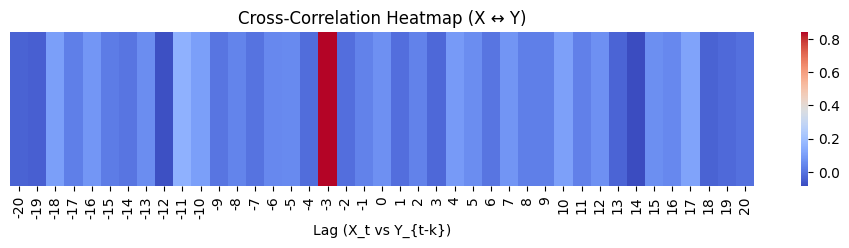

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.stattools import adfuller, ccf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.api import VAR
from statsmodels.tsa.arima.model import ARIMA


# =======================================================
# 1. 예시 데이터 생성 (stationary)
# =======================================================
np.random.seed(0)
n = 300

X = np.random.normal(size=n) # Stationary
Y = 0.6 * np.roll(X, 3) + np.random.normal(scale=0.4, size=n)  # lag=3 관계, Stationary

df = pd.DataFrame({"X": X, "Y": Y})


# =======================================================
# 2. ADF Test
# =======================================================
def adf_test(series, name):
    res = adfuller(series)
    print(f"[ADF] {name}")
    print(f"  Test statistic : {res[0]:.4f}")
    print(f"  p-value        : {res[1]:.4f}")
    print(f"  Critical values: {res[4]}")
    print("  => Stationary\n" if res[1] < 0.05 else "  => NOT Stationary\n")

adf_test(df["X"], "X")
adf_test(df["Y"], "Y")


# =======================================================
# 3. Pearson Correlation & CCF
# =======================================================
corr = df["X"].corr(df["Y"])
print(f"동시 상관계수 (Pearson): {corr:.4f}\n")

lags = 20
ccf_values = ccf(df["X"], df["Y"])[:lags]

plt.figure(figsize=(10,4))
plt.stem(range(lags), ccf_values, 
         #use_line_collection=True
         )
plt.axhline(0, color='black')
plt.title("Cross-Correlation Function (CCF)")
plt.xlabel("Lag: X_t vs Y_{t-k}")
plt.ylabel("Correlation")
plt.show()


# =======================================================
# 4. ACF / PACF
# =======================================================
fig, ax = plt.subplots(2, 2, figsize=(12, 8))

plot_acf(df["X"], ax=ax[0,0]); ax[0,0].set_title("ACF - X")
plot_pacf(df["X"], method="ywm", ax=ax[0,1]); ax[0,1].set_title("PACF - X")
plot_acf(df["Y"], ax=ax[1,0]); ax[1,0].set_title("ACF - Y")
plot_pacf(df["Y"], method="ywm", ax=ax[1,1]); ax[1,1].set_title("PACF - Y")

plt.tight_layout()
plt.show()


# =======================================================
# 5. Granger Causality Test
# =======================================================
print("===== Granger Causality Test: Does X → Y? =====")
grangercausalitytests(df[["Y", "X"]], maxlag=5, verbose=True)

print("\n===== Granger Causality Test: Does Y → X? =====")
grangercausalitytests(df[["X", "Y"]], maxlag=5, verbose=True)


# =======================================================
# 6. VAR 자동 Lag 선택 (AIC 기반)
# =======================================================
print("\n===== VAR Lag Order Selection (AIC 기반) =====")
model = VAR(df)
lag_selection = model.select_order(maxlags=15)
print(lag_selection.summary())

best_lag = lag_selection.aic
print(f"\n🔎 AIC 기준 최적 lag = {best_lag}\n")


# VAR 모델 적합
var_model = model.fit(best_lag)
print(var_model.summary())

forecast = var_model.forecast(df.values[-best_lag:], steps=5)
print("\nVAR Forecast (5 steps):\n", forecast)


# =======================================================
# 7. ARIMA 모델 (X 변수)
# =======================================================
arima_model = ARIMA(df["X"], order=(1,0,1))
arima_results = arima_model.fit()

print("\n==== ARIMA Model Summary (X variable) ====")
print(arima_results.summary())

arima_forecast = arima_results.forecast(5)
print("\nARIMA Forecast (next 5 steps):")
print(arima_forecast)



# =======================================================
# 8. Cross-Correlation Heatmap (X ↔ Y lag matrix)
# =======================================================
def cross_corr_matrix(x, y, max_lag=20):
    """
    x_t vs y_{t-k} cross correlation matrix (lags: -max_lag ~ +max_lag)
    """
    lags = range(-max_lag, max_lag + 1)
    corr_values = []

    for lag in lags:
        if lag < 0:
            corr = np.corrcoef(x[:lag], y[-lag:])[0,1]
        elif lag > 0:
            corr = np.corrcoef(x[lag:], y[:-lag])[0,1]
        else:
            corr = np.corrcoef(x, y)[0,1]
        corr_values.append(corr)

    return pd.DataFrame({"lag": lags, "corr": corr_values})


heat_df = cross_corr_matrix(df["X"].values, df["Y"].values, max_lag=20)
heat_df_pivot = heat_df.pivot_table(values="corr", #index=[0],
                                columns="lag")

print(f'np.argmax(heat_df_pivot): {np.argmax(heat_df_pivot)}')
print(f'lag = heat_df_pivot.columns[np.argmax(heat_df_pivot)]: {heat_df_pivot.columns[np.argmax(heat_df_pivot)]}')
print(f'cross_corr = heat_df_pivot.iloc[:, np.argmax(heat_df_pivot)]: {heat_df_pivot.iloc[:, np.argmax(heat_df_pivot)].values}')

plt.figure(figsize=(12,2))
sns.heatmap(heat_df_pivot,
            cmap="coolwarm", annot=False, cbar=True)
plt.title("Cross-Correlation Heatmap (X ↔ Y)")
plt.xlabel("Lag (X_t vs Y_{t-k}) (if Lag < 0: X_t is leading)")
plt.yticks([])
plt.show()


In [31]:
# =======================================================
# 5. Granger Causality Test
# =======================================================
print("===== Granger Causality Test: Does X → Y? =====")
grangercausalitytests(df[["Y", "X"]], maxlag=5, verbose=True)

print("\n===== Granger Causality Test: Does Y → X? =====")
grangercausalitytests(df[["X", "Y"]], maxlag=5, verbose=True)

===== Granger Causality Test: Does X → Y? =====

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.3174  , p=0.5736  , df_denom=296, df_num=1
ssr based chi2 test:   chi2=0.3206  , p=0.5713  , df=1
likelihood ratio test: chi2=0.3204  , p=0.5714  , df=1
parameter F test:         F=0.3174  , p=0.5736  , df_denom=296, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.1506  , p=0.8602  , df_denom=293, df_num=2
ssr based chi2 test:   chi2=0.3064  , p=0.8579  , df=2
likelihood ratio test: chi2=0.3063  , p=0.8580  , df=2
parameter F test:         F=0.1506  , p=0.8602  , df_denom=293, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=234.5284, p=0.0000  , df_denom=290, df_num=3
ssr based chi2 test:   chi2=720.5683, p=0.0000  , df=3
likelihood ratio test: chi2=365.7374, p=0.0000  , df=3
parameter F test:         F=234.5284, p=0.0000  , df_denom=290, df_num=3

Granger Causality
number of lags (no zero) 4


/home/yypark/miniconda3/envs/ai_env/lib/python3.12/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/home/yypark/miniconda3/envs/ai_env/lib/python3.12/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


{np.int64(1): ({'ssr_ftest': (np.float64(0.02689436822633126),
    np.float64(0.8698469826738869),
    np.float64(296.0),
    np.int64(1)),
   'ssr_chi2test': (np.float64(0.02716694628267921),
    np.float64(0.8690825243360636),
    np.int64(1)),
   'lrtest': (np.float64(0.027165712171836276),
    np.float64(0.8690854711292749),
    np.int64(1)),
   'params_ftest': (np.float64(0.026894368226335355),
    np.float64(0.8698469826738869),
    np.float64(296.0),
    1.0)},
   array([[0., 1., 0.]])]),
 np.int64(2): ({'ssr_ftest': (np.float64(0.12781093903161483),
    np.float64(0.8800687774127122),
    np.float64(293.0),
    np.int64(2)),
   'ssr_chi2test': (np.float64(0.25998402615304583),
    np.float64(0.8781024442295811),
    np.int64(2)),
   'lrtest': (np.float64(0.2598706831884101),
    np.float64(0.878152209006831),
    np.int64(2)),
   'params_ftest': (np.float64(0.12781093903162175),
    np.float64(0.8800687774126835),
    np.float64(293.0),
    2.0)},
   array([[0., 0., 1., 0., 0.]

In [32]:
# =======================================================
# 6. VAR 자동 Lag 선택 (AIC 기반)
# =======================================================



print("\n===== VAR Lag Order Selection (AIC 기반) =====")
model = VAR(df)
lag_selection = model.select_order(maxlags=15)
print(lag_selection.summary())

best_lag = lag_selection.aic
print(f"\n🔎 AIC 기준 최적 lag = {best_lag}\n")


# VAR 모델 적합
var_model = model.fit(best_lag)
print(var_model.summary())

forecast = var_model.forecast(df.values[-best_lag:], steps=5)
print("\nVAR Forecast (5 steps):\n", forecast)



===== VAR Lag Order Selection (AIC 기반) =====
 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0      -0.5858     -0.5602      0.5567     -0.5755
1      -0.5615     -0.4846      0.5703     -0.5307
2      -0.5365     -0.4084      0.5848     -0.4852
3      -1.749*     -1.569*     0.1740*     -1.677*
4       -1.743      -1.512      0.1751      -1.650
5       -1.718      -1.436      0.1795      -1.605
6       -1.696      -1.363      0.1834      -1.562
7       -1.726      -1.342      0.1779      -1.572
8       -1.729      -1.294      0.1774      -1.555
9       -1.714      -1.227      0.1803      -1.518
10      -1.700      -1.162      0.1827      -1.485
11      -1.683      -1.094      0.1859      -1.447
12      -1.680      -1.039      0.1865      -1.423
13      -1.657     -0.9645      0.1910      -1.379
14      -1.659     -0.9154      0.1907      -1.361
15      -1.633     -0.8381      0.19

In [34]:



# =======================================================
# 7. ARIMA 모델 (X 변수)
# =======================================================
arima_model = ARIMA(df["X"], order=(1,0,1)) # d=0 로 차분안한  stationary 변수
arima_results = arima_model.fit()

print("\n==== ARIMA Model Summary (X variable) ====")
print(arima_results.summary())

arima_forecast = arima_results.forecast(2)
print("\nARIMA Forecast (next 2 steps):")
print(arima_forecast)


==== ARIMA Model Summary (X variable) ====
                               SARIMAX Results                                
Dep. Variable:                      X   No. Observations:                  300
Model:                 ARIMA(1, 0, 1)   Log Likelihood                -424.036
Date:                Sun, 23 Nov 2025   AIC                            856.072
Time:                        16:37:58   BIC                            870.887
Sample:                             0   HQIC                           862.001
                                - 300                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0475      0.095      0.498      0.618      -0.139       0.234
ar.L1          0.9448      0.066     14.249      0.000       0.815       1.075
ma.L1   

## 비정상 변수를 먼저 차분·변환하여 stationary로 만든 전/후 상관 비교 분석

아래는 정상 변수와 비정상 변수를 생성하고,

- 원본 상태에서 상관을 계산한 경우(가성상관 발생)

- 비정상 변수를 차분하여 정상화한 후 상관을 계산한 경우
를 비교하는 파이썬 예시 코드

원본 상태 상관 (spurious correlation): 0.03665235896648336
차분 후 상관: -0.030473224038246628
[ADF] y-NS
  Test statistic : -0.7726
  p-value        : 0.8270
  Critical values: {'1%': np.float64(-3.452713099849546), '5%': np.float64(-2.871387839457783), '10%': np.float64(-2.5720171933352485)}
  => NOT Stationary

[ADF] dy-S, 1st-diff
  Test statistic : -10.7523
  p-value        : 0.0000
  Critical values: {'1%': np.float64(-3.452713099849546), '5%': np.float64(-2.871387839457783), '10%': np.float64(-2.5720171933352485)}
  => Stationary



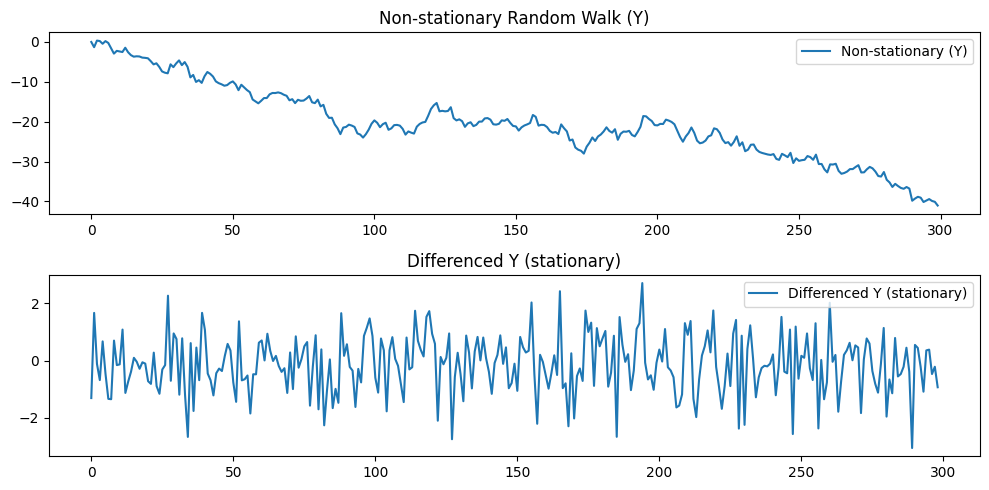

In [30]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

from statsmodels.tsa.stattools import adfuller, ccf

np.random.seed(0)

# -----------------------------
# 1. 정상 변수 생성 (white noise)
# -----------------------------
x = np.random.normal(0, 1, 300)

# -----------------------------
# 2. 비정상 변수 생성 (랜덤워크)
# -----------------------------
y = np.zeros(300)
for t in range(1, 300):
    y[t] = y[t-1] + np.random.normal()

# -----------------------------
# 3. 원본 상태에서 상관 계산
# -----------------------------
corr_original = np.corrcoef(x, y)[0, 1]

# -----------------------------
# 4. 비정상 변수 차분 → stationary로 변환
# -----------------------------
dy = np.diff(y)  # 1st difference

# x와 길이를 맞추기 위해 x[1:] 사용
corr_diff = np.corrcoef(x[1:], dy)[0, 1]

print("원본 상태 상관 (spurious correlation):", corr_original)
print("차분 후 상관:", corr_diff)


adf_test(y, "y-NS")
adf_test(dy, "dy-S, 1st-diff")

# -----------------------------
# 5. 결과 시각화
# -----------------------------
plt.figure(figsize=(10,5))
plt.subplot(2,1,1)
plt.plot(y, label="Non-stationary (Y)")
plt.title("Non-stationary Random Walk (Y)")
plt.legend()

plt.subplot(2,1,2)
plt.plot(dy, label="Differenced Y (stationary)")
plt.title("Differenced Y (stationary)")
plt.legend()

plt.tight_layout()
plt.show()
